<a href="https://colab.research.google.com/github/UEC-MaTa/News_Aggregator/blob/main/20230708%E6%99%82%E7%82%B9_retry_News_Aggregator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# News Aggregator
（参考）演習：StackOverflow の質問に対するマルチクラス分類
ニュースのテキスト分類を応用してみる

In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re
from tensorflow import keras
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.models import Sequential
from keras.utils.np_utils import to_categorical

In [ ]:
print(tf.__version__)

2.12.0


In [ ]:
# 下記セルを実行すると、authorization codeの入力を求められます。
# 出力されたリンク先をクリックし、Googleアカウントにログインし、
# authorization codeをコピーし、貼り付けをおこなってください。
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd

#newsCorpora.csv
newsCorpora = pd.read_csv('/content/drive/MyDrive/Tensorflow/NewsAggregator/newsCorpora.csv',sep='\t',  names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
display(newsCorpora.shape)
display(newsCorpora)

(422419, 8)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027
...,...,...,...,...,...,...,...,...
422414,422933,Surgeons to remove 4-year-old's rib to rebuild...,http://www.cbs3springfield.com/story/26378648/...,WSHM-TV,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.cbs3springfield.com,1409229190251
422415,422934,Boy to have surgery on esophagus after battery...,http://www.wlwt.com/news/boy-to-have-surgery-o...,WLWT Cincinnati,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.wlwt.com,1409229190508
422416,422935,Child who swallowed battery to have reconstruc...,http://www.newsnet5.com/news/local-news/child-...,NewsNet5.com,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.newsnet5.com,1409229190771
422417,422936,Phoenix boy undergoes surgery to repair throat...,http://www.wfsb.com/story/26368078/phoenix-boy...,WFSB,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.wfsb.com,1409229191071


In [ ]:
#2pageSessions.csv
twopageSessions = pd.read_csv('/content/drive/MyDrive/Tensorflow/NewsAggregator/2pageSessions.csv',sep='\t',  names=['STORY', 'HOSTNAME', 'CATEGORY', 'URL'])
display(twopageSessions.shape)
display(twopageSessions)

(15516, 4)

,STORY,HOSTNAME,CATEGORY,URL
0,dxyGGb4iN9Cs9aMZTKQpJeoiQfruM,techcrunch.com,b,http://techcrunch.com/ http://techcrunch.com/2...
1,dxyGGb4iN9Cs9aMZTKQpJeoiQfruM,techcrunch.com,b,http://techcrunch.com/ecommerce/ http://techcr...
2,dxyGGb4iN9Cs9aMZTKQpJeoiQfruM,www.bnn.ca,b,http://www.bnn.ca/News/2014/ http://www.bnn.ca...
3,dxyGGb4iN9Cs9aMZTKQpJeoiQfruM,www.bnn.ca,b,http://www.bnn.ca/news http://www.bnn.ca/News/...
4,dxyGGb4iN9Cs9aMZTKQpJeoiQfruM,www.bnn.ca,b,http://www.bnn.ca/News/News-Listing.aspx?Secto...
...,...,...,...,...
15511,dkPjabOt_3c58pM7cXTzwf0VDxtQM,www.upi.com,b,http://www.upi.com/ http://www.upi.com/Busines...
15512,dkPjabOt_3c58pM7cXTzwf0VDxtQM,www.webpronews.com,b,http://www.webpronews.com/ http://www.webprone...
15513,d3DTRVmvpPPpa8MG61j9MfjG4GkuM,www.smh.com.au,b,http://www.theage.com.au/travel/traveller-tips...
15514,d3DTRVmvpPPpa8MG61j9MfjG4GkuM,www.smh.com.au,b,http://www.theage.com.au/travel http://www.smh...


In [ ]:
newsCorpora.dtypes

ID            int64
TITLE        object
URL          object
PUBLISHER    object
CATEGORY     object
STORY        object
HOSTNAME     object
TIMESTAMP     int64
dtype: object

In [ ]:
twopageSessions.dtypes

STORY       object
HOSTNAME    object
CATEGORY    object
URL         object
dtype: object

In [ ]:
#creating a new dataset with only relevant features.
ds = newsCorpora[['TITLE','CATEGORY']]

print(ds.head()) #★

#shuffling rows with the help of sample, here (frac = 1) means return all rows
ds = ds.sample(frac=1).reset_index(drop=True)

print(ds.head())

                                               TITLE CATEGORY
0  Fed official says weak data caused by weather,...        b
1  Fed's Charles Plosser sees high bar for change...        b
2  US open: Stocks fall after Fed official hints ...        b
3  Fed risks falling 'behind the curve', Charles ...        b
4  Fed's Plosser: Nasty Weather Has Curbed Job Gr...        b
                                               TITLE CATEGORY
0  What's Happening In Hip-Pop: Jimmy Fallon Gets...        e
1  Crisis in Iraq 'could see the price of petrol ...        b
2                      BNP to book 5.8bn euro charge        b
3       Gold price extends gains to 4-1/2 month high        b
4       Siemens And Mitsubishi Finalize Alstom Offer        b


drop=Falseは、あまり影響なし？

In [ ]:
ds.shape

(422419, 2)

In [ ]:
#checking for null values
ds.isnull().sum()

TITLE       0
CATEGORY    0
dtype: int64

In [ ]:
#M class has way less data than the orthers, thus the classes are unbalanced.
ds.CATEGORY.value_counts()

e    152469
b    115967
t    108344
m     45639
Name: CATEGORY, dtype: int64

<Axes: xlabel='CATEGORY', ylabel='count'>

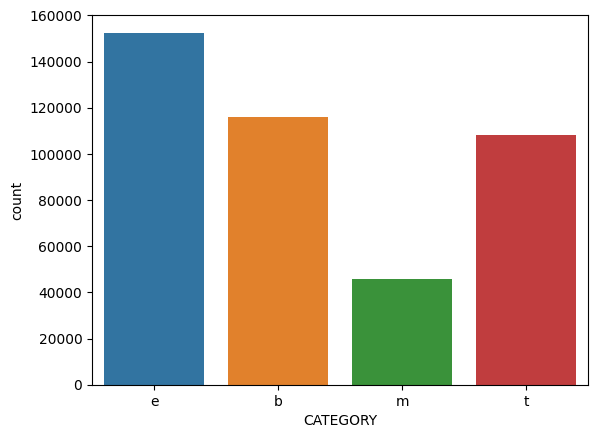

In [ ]:
#plotting graph for categories
sns.countplot(x = 'CATEGORY',data = ds)

In [ ]:
#I do aspire here to have balanced classes ★notebooke2c7d39000.ipynbより
#num_of_categories = 45000 ★いったん、制限なしで
#shuffled = data.reindex(np.random.permutation(data.index)) ★シャッフルは、上で実行済み
#https://docs.google.com/document/d/1yCGwcOrNaS-piPpez0hG_EKY4sqsNyRL4p7WQ_QQzy0/edit
shuffled = ds #★上でシャッフルしたdsをコピー
e = shuffled[shuffled['CATEGORY'] == 'e'] #[:num_of_categories]
b = shuffled[shuffled['CATEGORY'] == 'b'] #[:num_of_categories]
t = shuffled[shuffled['CATEGORY'] == 't'] #[:num_of_categories]
m = shuffled[shuffled['CATEGORY'] == 'm'] #[:num_of_categories]
concated = pd.concat([e,b,t,m], ignore_index=True)
#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['LABEL'] = 0

In [ ]:
concated #確認

,TITLE,CATEGORY,LABEL
85774,Miley Cyrus Mouths Off: 5 Awesome Things She's...,e,0
413093,'Epidemic?': Number of Adults Taking ADHD Medi...,m,0
9274,Eurovision fairytale for Europe's smallest nat...,e,0
177381,"US, SunTrust Announce Nearly $1B Settlement",b,0
99114,Cannes Awards Ceremony Celebrates Turkish Fami...,e,0
...,...,...,...
399191,Novel malaria vaccine made from blood of Tanza...,m,0
28685,Netanyahu sends condolences to families of Kan...,e,0
51551,VOTD: Solange Knowles Beating The Hell Out Of ...,e,0
413375,Hamilton: Prescription drug take back day is A...,m,0


In [ ]:
#One-hot encode the lab ★notebooke2c7d39000.ipynbより
concated.loc[concated['CATEGORY'] == 'e', 'LABEL'] = 0
concated.loc[concated['CATEGORY'] == 'b', 'LABEL'] = 1
concated.loc[concated['CATEGORY'] == 't', 'LABEL'] = 2
concated.loc[concated['CATEGORY'] == 'm', 'LABEL'] = 3
print(concated['LABEL'][:10])
labels = to_categorical(concated['LABEL'], num_classes=4)
print(labels[:10])
#print('★', concated) #★
if 'CATEGORY' in concated.keys():
    concated.drop(['CATEGORY'], axis=1) #★このif文の意味合いは分からず

print('★★', concated) #★
'''
 [1. 0. 0. 0.] e
 [0. 1. 0. 0.] b
 [0. 0. 1. 0.] t
 [0. 0. 0. 1.] m
'''

85774     0
413093    3
9274      0
177381    1
99114     0
349950    2
172300    1
126634    0
33384     0
13371     0
Name: LABEL, dtype: int64
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
★★                                                     TITLE CATEGORY  LABEL
85774   Miley Cyrus Mouths Off: 5 Awesome Things She's...        e      0
413093  'Epidemic?': Number of Adults Taking ADHD Medi...        m      3
9274    Eurovision fairytale for Europe's smallest nat...        e      0
177381        US, SunTrust Announce Nearly $1B Settlement        b      1
99114   Cannes Awards Ceremony Celebrates Turkish Fami...        e      0
...                                                   ...      ...    ...
399191  Novel malaria vaccine made from blood of Tanza...        m      3
28685   Netanyahu sends condolences to families of Kan...        e      0
51551   VOTD: Solange Knowles Beat

'\n [1. 0. 0. 0.] e\n [0. 1. 0. 0.] b\n [0. 0. 1. 0.] t\n [0. 0. 0. 1.] m\n'

In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ') #original was '<br />'
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

★  
**tf.strings.regex_replace**  
正規表現 patternにマッチする inputの要素を rewriteで置き換える。

tf.strings.regex_replace(
    input, pattern, rewrite, replace_global=True, name=None
)  
tf.strings.regex_replace("Text with tags.<br /><b>contains html</b>",
                         "<[^>]+>", " ")  
<tf.Tensor: shape=(), dtype=string, numpy=b'Text with tags.  contains html '>  

Args  
**input**	string Tensor,処理するソース文字列。  
**pattern**	文字列またはスカラー文字列 Tensor,使用する正規表現、詳細は https://github.com/google/re2/wiki/Syntax を参照。  
**rewrite**	文字列またはスカラー文字列 Tensor、マッチ置換で使用する値は、バックスラッシュエスケープの数字(\ 1から\ 9)をサポートします。  
**replace_global**	bool, Trueの場合は重複しないすべてのマッチを置換し、それ以外の場合は最初のマッチのみを置換する。  
**name**	操作の名前(オプション)。

**Returns**  
inputと同形状の文字列 Tensorを指定置換した。

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

**tf.keras.layers.TextVectorization**  https://runebook.dev/ja/docs/tensorflow/keras/layers/textvectorization  
TensorFlowの tf.keras.layers.TextVectorizationレイヤーは、文字列入力(テキストなど)のバッチを数値テンソルのバッチに変換する前処理レイヤーである。文字列を単語にトークン化し、語彙に基づいて各単語を整数にマッピングし、各文字列を整数のシーケンスとして符号化することでこれを実現する。この層は、感情分析や言語モデリングなどの自然言語処理タスクに有用である。

TextVectorizationレイヤーの主な特徴として、カスタムのトークン化と正規化のサポート、設定可能な語彙サイズと最大配列長、入力データに語彙を適応させる機能などがあります。さらに、他のKerasレイヤーと組み合わせて使用することで、幅広い自然言語処理タスクのためのカスタムモデルを構築することができます。

tf.keras.layers.TextVectorization(  
    max_tokens=None,  
    standardize='lower_and_strip_punctuation',  
    split='whitespace',  
    ngrams=None,  
    output_mode='int',  
    output_sequence_length=None,  
    pad_to_max_tokens=False,  
    vocabulary=None,  
    idf_weights=None,  
    sparse=False,  
    ragged=False,  
    **kwargs  
)  

**Args**  
**max_tokens**	このレイヤーのボキャブラリーの最大サイズ。これは、語彙を適合させるとき、または pad_to_max_tokens=Trueを設定するときにのみ指定する必要があります。なお、この語彙にはOOVトークンが1つ含まれているので、有効なトークン数は (max_tokens-1-(1 if output_mode =="int" else 0))です。  
**standardize**	入力テキストに適用する標準化のためのオプションの仕様。値として指定できる。  
None:標準化されていない。
"lower_and_strip_punctuation":テキストは小文字になり、句読点はすべて削除されます。
"lower":文字は小文字になります。
"strip_punctuation" :句読点はすべて削除されます。
呼び出し可能であること。入力は呼び出し可能な関数に渡され、標準化されて返されるはずです。  
**split**	入力テキストを分割するためのオプションの指定。値は以下の通り。
None:割れがない。
"whitespace":空白文字で分割される。
"character":ユニコード文字ごとに分割する。
呼び出し可能。標準化された入力は、呼び出し可能な関数に渡され、その関数は分割されて返される必要があります。  
**ngrams**	分割された入力テキストから作成するngramを指定するオプション。整数を渡すと、その整数までのngramが作成され、整数のタプルを渡すと、そのタプルで指定した値のngramが作成されます。Noneを渡すと、ngramは作成されない。  
**output_mode**	レイヤーの出力に関するオプションの指定。 "int", "multi_hot", "count", "tf_idf"のいずれかを指定し,以下のようにレイヤーを構成する。
"int":分割文字列トークン1個につき1個の整数インデックスを出力する。 output_mode =="int" の場合,0 はマスクされた位置のために予約される.これにより,ボキャブラリーのサイズは max_tokens-1 ではなく max_tokens-2 となる.
"multi_hot":バッチごとに、vocab_sizeまたはmax_tokensサイズのint配列を1つ出力し、そのインデックスにマップされたトークンがバッチアイテムに少なくとも1回は存在するすべての要素に1を含む。
"count": "multi_hot"と同様であるが、int配列にそのインデックスのトークンがバッチアイテムに出現した回数をカウントしている。
"tf_idf": "multi_hot"と同様ですが、TF-IDFアルゴリズムを適用して、各トークンスロットの値を求めます。 "int"出力では、任意の形状の入力と出力がサポートされる。その他の出力モードでは、現在、ランク1入力(分割後はランク2出力)のみがサポートされています。  
**output_sequence_length**	INTモードでのみ有効です。設定された場合、出力は時間次元が正確に output_sequence_lengthの値になるようにパディングまたは切り捨てられ、分割ステップの結果のトークンの数にかかわらず、 (batch_size,output_sequence_length)の形のテンソルになる。デフォルトはNoneです。  
**pad_to_max_tokens**	"multi_hot", "count", "tf_idf" モードでのみ有効です。Trueの場合、語彙のユニークトークンの数がmax_tokensより少なくても、出力はその特徴軸が max_tokensにパディングされ、語彙のサイズに関係なく (batch_size,max_tokens)の形のテンソルになる。デフォルトはFalseです。  
**vocabulary**	オプション。文字列の配列、またはテキストファイルへの文字列パスのどちらかを指定する。配列を渡す場合、文字列の語彙を含むタプル、リスト、1次元numpy配列、または1次元テンソルを渡すことができる。ファイルパスを渡す場合、ファイルには語彙の各用語につき1行が含まれる必要がある。この引数が設定されている場合、レイヤーを adapt()する必要はない。  
**idf_weights**	output_modeが "tf_idf"の場合のみ有効。語彙と同じ長さのタプル、リスト、1次元のnumpy配列、または1次元テンソル。 vocabularyが設定され、 output_modeが "tf_idf"の場合、この引数を与える必要がある。  
**ragged**	ブール値です。 "int"出力モードにのみ適用される。Trueの場合、文字列分割後に各シーケンスが異なる長さになる可能性がある、密な Tensorの代わりに RaggedTensorを返します。デフォルトはFalseです。  
**sparse**	ブール値です。 "multi_hot", "count", "tf_idf" 出力モードのみに適用可能です。Trueの場合、密集した Tensorの代わりに SparseTensorを返します。 デフォルトはFalseです。

In [ ]:
# Make a text-only dataset (without labels), then call adapt
train_text = concated["TITLE"] #★original was ds
vectorize_layer.adapt(train_text)
print(vectorize_layer(train_text).shape) #★

(422419, 250)


In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label
  #expand_dimsメソッドを用いて、tensorflow2.0で生成したtensorの次元を増やす
  #https://www.tcom242242.net/entry/python-basic/tensorflow2/tensorflow2-0tensor-tf-expand_dims/

  #tf.expand_dimsを使用する場合は、拡張する元のTensorと拡張したい軸をaxis引数で指定します。例えば、先頭に追加したい場合には「axis=0」とします。
  #上記の例では、末尾に追加する例では「axis=-1」としています。もちろん上記の例で「axis=1」としても同様の結果が得られますが、
  #末尾に追加する場合には「axis=-1」で指定する場合も多いですので覚えておきましょう。
  #https://tech.nkhn37.net/tensorflow-tensor-expand-dims/

上記のように、各トークンは整数に置き換えられています。レイヤーで `.get_vocabulary()` を呼び出すことにより、各整数が対応するトークン（文字列）を検索できます。

In [ ]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[3])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  girlfriend
 313 --->  search
 313 --->  the
Vocabulary size: 10000


In [ ]:
# ★
for i in range(20):
  print(i, " ---> ",vectorize_layer.get_vocabulary()[i])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

0  --->  
1  --->  [UNK]
2  --->  to
3  --->  the
4  --->  in
5  --->  of
6  --->  for
7  --->  on
8  --->  and
9  --->  a
10  --->  with
11  --->  new
12  --->  at
13  --->  is
14  --->  us
15  --->  as
16  --->  from
17  --->  after
18  --->  google
19  --->  by
Vocabulary size: 10000


In [ ]:
concated['CATEGORY'] #★

85774     e
413093    m
9274      e
177381    b
99114     e
         ..
399191    m
28685     e
51551     e
413375    m
224219    b
Name: CATEGORY, Length: 422419, dtype: object

In [ ]:
#splitting the Dataset into Train and Test set
x_train,x_test,y_train,y_test=train_test_split(concated['TITLE'],labels,test_size=0.2,random_state=42)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(337935,) (337935, 4)
(84484,) (84484, 4)


In [ ]:
x_train #★

118251    Home WhatsOn 'Ferocious talent' Farley Mowat d...
260858    WWE Money in the Bank 2014: Live Stream, WWE N...
18526     Jay Leno will receive the Mark Twain Prize for...
286614                Galaxy Tab S 10.1 VS Pro VS Note 12.2
11695     'Dancing With the Stars' recap: The winner and...
                                ...                        
368877    Microsoft criticised after scanning blogger's ...
120768    Kiefer Sutherland responds to Freddie Prinze J...
319933    Microsoft Said To Drop Windows Phone Fees For ...
133659    Kris Jenner is such a fan of her son-in-law Ka...
115265       Jay Leno to get nation's top humor prize in DC
Name: TITLE, Length: 337935, dtype: object

In [ ]:
y_train #★

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

モデルをトレーニングする準備がほぼ整いました。最後の前処理ステップとして、トレーニング、検証、およびデータセットのテストのために前に作成した TextVectorization レイヤーを適用します。

In [ ]:
train_ds = vectorize_text(x_train,y_train)
val_ds = vectorize_text(x_test,y_test)
#test_ds = raw_test_ds.map(vectorize_text)

In [ ]:
print(train_ds)

(<tf.Tensor: shape=(337935, 250), dtype=int64, numpy=
array([[ 111, 5815,    1, ...,    0,    0,    0],
       [ 969,  525,    4, ...,    0,    0,    0],
       [ 216, 4781,   24, ...,    0,    0,    0],
       ...,
       [  41, 1004,    2, ...,    0,    0,    0],
       [2420,  826,   13, ...,    0,    0,    0],
       [ 216, 4781,    2, ...,    0,    0,    0]])>, array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32))


In [ ]:
print(train_ds[0])

tf.Tensor(
[[ 111 5815    1 ...    0    0    0]
 [ 969  525    4 ...    0    0    0]
 [ 216 4781   24 ...    0    0    0]
 ...
 [  41 1004    2 ...    0    0    0]
 [2420  826   13 ...    0    0    0]
 [ 216 4781    2 ...    0    0    0]], shape=(337935, 250), dtype=int64)


In [ ]:
print(train_ds[1])

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [ ]:
print(val_ds)
#print(test_ds)

(<tf.Tensor: shape=(84484, 250), dtype=int64, numpy=
array([[   1,    1, 7843, ...,    0,    0,    0],
       [ 444,  226,   52, ...,    0,    0,    0],
       [7004,   88, 1145, ...,    0,    0,    0],
       ...,
       [3402, 3630,  429, ...,    0,    0,    0],
       [2447, 2186,  131, ...,    0,    0,    0],
       [ 124,  134,   76, ...,    0,    0,    0]])>, array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32))


In [ ]:
"""
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
#test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
"""

'\nAUTOTUNE = tf.data.AUTOTUNE\n\ntrain_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)\nval_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)\n#test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)\n'

In [ ]:
print(train_ds)
print(val_ds)
#print(test_ds)

(<tf.Tensor: shape=(337935, 250), dtype=int64, numpy=
array([[ 111, 5815,    1, ...,    0,    0,    0],
       [ 969,  525,    4, ...,    0,    0,    0],
       [ 216, 4781,   24, ...,    0,    0,    0],
       ...,
       [  41, 1004,    2, ...,    0,    0,    0],
       [2420,  826,   13, ...,    0,    0,    0],
       [ 216, 4781,    2, ...,    0,    0,    0]])>, array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32))
(<tf.Tensor: shape=(84484, 250), dtype=int64, numpy=
array([[   1,    1, 7843, ...,    0,    0,    0],
       [ 444,  226,   52, ...,    0,    0,    0],
       [7004,   88, 1145, ...,    0,    0,    0],
       ...,
       [3402, 3630,  429, ...,    0,    0,    0],
       [2447, 2186,  131, ...,    0,    0,    0],
       [ 124,  134,   76, ...,    0,    0,    0]])>, array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       ..

In [ ]:
print(train_ds[0][0])

tf.Tensor(
[ 111 5815    1 4289 5271 5426  139   12 5203    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [ ]:
print("Lavel", train_ds[1][0])

Lavel [1. 0. 0. 0.]


In [ ]:
X_train, X_test, y_train, y_test = train_ds[0], val_ds[0], train_ds[1], val_ds[1]

In [ ]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

(TensorShape([337935, 250]), (337935, 4), TensorShape([84484, 250]), (84484, 4))


### モデルを作成する

ニューラルネットワークを作成します。

In [ ]:
epochs = 10
emb_dim = 128
batch_size = 256
labels[:2]

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

max_features = 10000
sequence_length = 250

In [ ]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()
model.add(Embedding(max_features, emb_dim, input_length=sequence_length))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 128)          1280000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 1,329,668
Trainable params: 1,329,668
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1057/1057 [==============================] - 1974s 2s/step - loss: 1.3138 - acc: 0.3600 - val_

In [ ]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2641/2641 [==============================] - 147s 56ms/step - loss: 1.3136 - acc: 0.3605
Test set
  Loss: 1.314
  Accuracy: 0.360


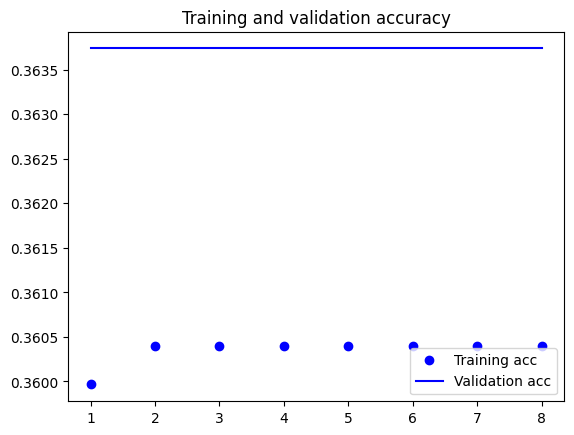

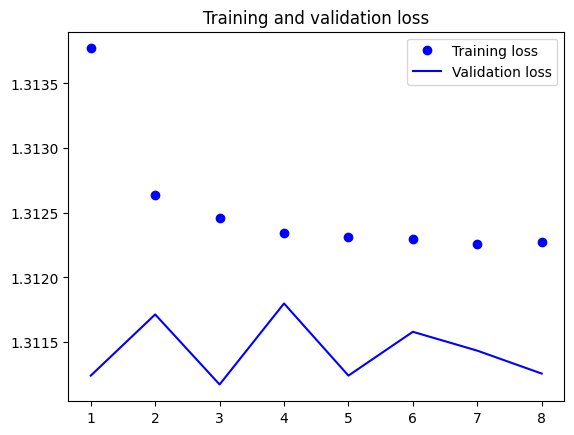

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
txt = ["Regular fast food eating linked to fertility issues in women"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['entertainment', 'bussiness', 'science/tech', 'health']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 311ms/step
[[7.0627568e-05 5.2736496e-04 5.6742025e-05 9.9934524e-01]] health


確認：   
1 Fed official says weak data caused by weather, should not slow taper http://www.latimes.com/business/money/la-fi-mo-federal-reserve-plosser-stimulus-economy-20140310,0,1312750.story\?track=rss Los Angeles Times **b**

99457 Rio 2' is king of the jungle http://bostonherald.com/entertainment/movies/movie_reviews/2014/04/rio_2_is_king_of_the_jungle Boston Herald **e**

309370 BMW, Ford, Chrysler join Japanese automakers in airbag recall http://kitchener.ctvnews.ca/bmw-ford-chrysler-join-japanese-automakers-in-airbag-recall-1.1882231 CTV News **t**

422937 Phoenix boy undergoes surgery to repair throat damage - CBS 3 Springfield ... http://www.cbs3springfield.com/story/26368078/phoenix-boy-undergoes-surgery-to-repair-throat-damage-from-button-battery WSHM-TV **m**


In [ ]:
txt = ["Fed official says weak data caused by weather, should not slow taper"] #確認
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['entertainment', 'bussiness', 'science/tech', 'health']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 133ms/step
[[7.5025175e-04 9.9534166e-01 2.5763419e-03 1.3317269e-03]] bussiness


In [ ]:
txt = ["Rio 2' is king of the jungle"] #確認
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['entertainment', 'bussiness', 'science/tech', 'health']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 47ms/step
[[9.9847132e-01 7.6254108e-04 5.5303791e-04 2.1319538e-04]] entertainment


In [ ]:
txt = ["BMW, Ford, Chrysler join Japanese automakers in airbag recall"] #確認
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['entertainment', 'bussiness', 'science/tech', 'health']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 184ms/step
[[1.3762778e-04 3.8258236e-02 9.6144396e-01 1.6023674e-04]] science/tech


In [ ]:
txt = ["Phoenix boy undergoes surgery to repair throat damage"] #確認
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['entertainment', 'bussiness', 'science/tech', 'health']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 43ms/step
[[2.7482520e-04 9.1161095e-03 3.8212218e-04 9.9022698e-01]] health


# **以下は、削除する。StackOverflowマルチクラス分類からのもの。**

In [ ]:
embedding_dim = 16

In [ ]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)]) #4 つの出力クラスがあるため、モデルの最後のレイヤーを Dense(4) に変更します。

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
__________________________________________________

In [ ]:
model.input_shape #★

(None, None)

### 損失関数とオプティマイザ

モデルをトレーニングするには、損失関数とオプティマイザが必要です。これは二項分類問題であり、モデルは確率（シグモイドアクティベーションを持つ単一ユニットレイヤー）を出力するため、`losses.BinaryCrossentropy` 損失関数を使用します。

損失関数の候補はこれだけではありません。例えば、`mean_squared_error`（平均二乗誤差）を使うこともできます。しかし、一般的には、確率を扱うには`binary_crossentropy`の方が適しています。`binary_crossentropy`は、確率分布の間の「距離」を測定する尺度です。今回の場合には、真の分布と予測値の分布の間の距離ということになります。

★
モデルをコンパイルするときは、損失を tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) に変更します。これは、各クラスのラベルが整数である場合に、マルチクラス分類問題に使用する正しい損失関数です。(この場合、 0、1、2、または 3 のいずれかになります)。さらに、これはマルチクラス分類の問題であるため、メトリックを metrics=['accuracy'] に変更します (tf.metrics.BinaryAccuracy はバイナリ分類器にのみ使用されます)。

In [ ]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True), #original was BinaryCrossentropy(from_logits=True)
              optimizer='adam',
              metrics='accuracy')  #original was tf.metrics.BinaryAccuracy(threshold=0.0))

### モデルをトレーニングする

`dataset` オブジェクトを fit メソッドに渡すことにより、モデルをトレーニングします。

In [ ]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/50


ValueError: ignored

このエラーは、モデルが期待する入力数と提供された入力数の不一致によって通常発生します。この場合、モデル “sequential_1” は1つの入力を期待していますが、2つの入力テンソルが提供されました。Inputs received: [<tf.Tensor ‘IteratorGetNext:0’ shape=(None, 250) dtype=int64>, <tf.Tensor ‘IteratorGetNext:1’ shape=(None, 1) dtype=string>]。コードを確認して、入力データがモデルに正しく渡されていることを確認してください1。

TensorFlowでモデルが期待する入力数を確認するには、モデルのsummary()メソッドを使用することができます。このメソッドは、モデルのレイヤー、出力形状、パラメータ数などの詳細を表示します1。また、モデルをロードしてから、model.input_shapeを使用して入力形状を取得することもできます2。これらの方法を使用して、モデルが期待する入力数と提供された入力数を比較し、問題を特定することができます。

In [ ]:
config = model.get_config() # Returns pretty much every information about your model
print(config["layers"][0]["config"]["batch_input_shape"]) # returns a tuple of width, height and channels

(None, None)


In [ ]:
print(model)

### モデルを評価する

モデルがどのように実行するか見てみましょう。2 つの値が返されます。損失（誤差、値が低いほど良）と正確度です。

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

NameError: ignored

### 経時的な正解度と損失のグラフを作成する

`model.fit()` は、トレーニング中に発生したすべての情報を詰まったディクショナリを含む `History` オブジェクトを返します。

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

トレーニングと検証中に監視されている各メトリックに対して 1 つずつ、計 4 つのエントリがあります。このエントリを使用して、トレーニングと検証の損失とトレーニングと検証の正解度を比較したグラフを作成することができます。

経時的な精度をプロットする場合は、binary_accuracy および val_binary_accuracyをそれぞれ accuracy および val_accuracy に変更します。

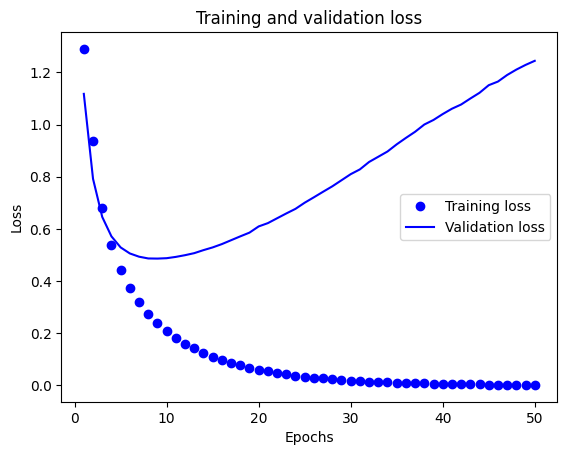

In [ ]:
acc = history_dict['accuracy'] #original was 'binary_accuracy'
val_acc = history_dict['val_accuracy'] #original was 'val_binary_accuracy'
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

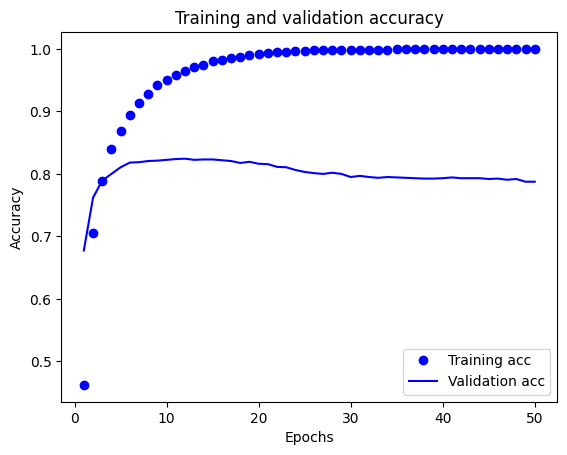

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

このグラフでは、点はトレーニングの損失と正解度を表し、実線は検証の損失と正解度を表します。

トレーニングの損失がエポックごとに*下降*し、トレーニングの正解度がエポックごとに*上昇*していることに注目してください。これは、勾配下降最適化を使用しているときに見られる現象で、イテレーションごとに希望する量を最小化します。

これは検証の損失と精度には当てはまりません。これらはトレーニング精度の前にピークに達しているようです。これが過適合の例で、モデルが、遭遇したことのないデータよりもトレーニングデータで優れたパフォーマンスを発揮する現象です。この後、モデルは過度に最適化し、テストデータに*一般化*しないトレーニングデータ*特有*の表現を学習します。

この特定のケースでは、検証の正解度が向上しなくなったときにトレーニングを停止することにより、過適合を防ぐことができます。これを行うには、`tf.keras.callbacks.EarlyStopping` コールバックを使用することができます。

★https://qiita.com/yukiB/items/f45f0f71bc9739830002
**EarlyStopping**
学習ループに収束判定を付与することができます．監視する値を設定し，それが収束したら自動的にループを抜ける処理になります．

keras.callbacks**.EarlyStopping**(monitor='val_loss', patience=0, verbose=0, mode='auto')

**arguments**	description
**monitor**	監視値指定．例えば，monitor='val_loss'
**patience**	ループの最低数
**verbose**	保存時に標準出力にコメントを出すか指定．{0, 1}
**mode**	上限，下限どちらの側に収束した場合に収束判定を出すかの規定．{auto, min, max}
上記の設定で，以下のように学習ループ途中であっても収束判定がかかり，ループから抜けることができます(下記の表示はverbose=1に設定していた場合)．

## モデルをエクスポートする

上記のコードでは、モデルにテキストをフィードする前に、`TextVectorization` レイヤーをデータセットに適用しました。モデルで生の文字列を処理できるようにする場合 (たとえば、展開を簡素化するため)、モデル内に `TextVectorization` レイヤーを含めることができます。これを行うには、トレーニングしたばかりの重みを使用して新しいモデルを作成します。

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 5s 19ms/step - loss: 1.4630 - accuracy: 0.7653
0.765250027179718


### 新しいデータの推論

新しい例の予測を取得するには、`model.predict()`を呼び出します。

★
Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python

In [ ]:
#Overstockflowから実例をコピペしてみた
examples = [
  #C##事例
  "I am developing a survivor game using the Qt framework with C++ language. Currently, I am implementing in-game saving functionality. My game consists of three main windows: MainWindow, ChooseScene, and Game. The gameplay interface is displayed in the Game window. However, since my windows are implemented as pointers, they contain multiple pointers internally. After saving a game, I clear the memory of the relevant pointers and set them to nullptr. When starting a new game, I allocate memory for them again. The problem I'm facing is that whenever I attempt to start a second round of a new game, the program crashes. I have a MainWindow window, and within its class, there is a pointer object called ChooseScene. Inside this pointer object, there is another pointer object called Game. When I click on Save and Exit, both the Game and ChooseScene windows are closed. At the same time, I use QSettings to save the data and delete these two pointers, which triggers the destructor of each object, deleting other pointer members within them. Finally, the MainWindow window appears. During the debugging process, I added numerous output statements to identify where the program crashes. Eventually, I discovered that the crash occurs right after executing the destructor of the Game object. However, I'm unsure how to resolve this issue. I'm seeking assistance to help identify and resolve this bug. Since I am a beginner, my code is quite lengthy, spanning over 1000 lines. If possible, it would be great to receive suggestions on how to fully implement the in-game saving functionality. Here is my code link:",
  #Java事例
  "I'm writing a ray tracer for which I need to cast rays from the screen into the world. I'm using the inverse of the view-projection-viewport matrix to get back from screen pixel coordinates to world space coordinates. I noticed by accident that two elements of the inverse matrix are always 0, no matter how or where I move, zoom, orbit, or spin the camera. I don't understand the projection matrix deeply enough to know why. This is a hopefully-relevant portion of my Matrix class:",
  #JavaScript事例
  "I was trying to update and delete data using forms with laravel but I cannot send the id using javascript. These are the scripts <script type=text/javascript> $(document).on(click, .edit_modal, function () {var data_id = $(this).data('id'); var data_name = $(this).data(name); $(.form-group #edit_name).val(data_name);});</script><script type=text/javascript>$(document).on(click, .delete_modal, function () {var data_id = $(this).data(id);});</script>And these are the for",
  #Python事例
  "I'm trying to make a small asynchronous application, based on a well-working code from GitHub here. I tried to alter it a little to fit my needs in this way main.py import asyncio from kernel.init import Init async def main(): init = Init() await init.loadSymbols() if __name__ == '__main__': loop = asyncio.new_event_loop() asyncio.run(main()) init.py"
]

export_model.predict(examples)

1/1 [==============================] - 0s 163ms/step


array([[1.0000000e+00, 5.6247762e-03, 1.4214570e-08, 2.3937970e-01],
       [7.2040498e-01, 6.2187579e-02, 1.4914745e-01, 9.7825456e-01],
       [9.9805123e-01, 5.9182366e-06, 9.9972266e-01, 7.6908812e-02],
       [6.0464587e-02, 1.5834800e-04, 3.6910981e-01, 9.9999946e-01]],
      dtype=float32)

In [ ]:
#Overstockflowから実例をコピペしてみた
examples = [
    "python",
    "java",
    "java script",
    "c"
]

export_model.predict(examples)

1/1 [==============================] - 0s 72ms/step


array([[0.5770613 , 0.6207191 , 0.48232028, 0.2525707 ],
       [0.5731874 , 0.36856958, 0.7113974 , 0.3645449 ],
       [0.46860415, 0.2534624 , 0.8119693 , 0.5873387 ],
       [0.5874888 , 0.54013544, 0.4845986 , 0.33849216]], dtype=float32)

モデル内にテキスト前処理ロジックを含めると、モデルを本番環境にエクスポートして展開を簡素化し、[トレーニング/テストスキュー](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew)の可能性を減らすことができます。

TextVectorization レイヤーを適用する場所を選択する際に性能の違いに留意する必要があります。モデルの外部で使用すると、GPU でトレーニングするときに非同期 CPU 処理とデータのバッファリングを行うことができます。したがって、GPU でモデルをトレーニングしている場合は、モデルの開発中に最高のパフォーマンスを得るためにこのオプションを使用し、デプロイの準備ができたらモデル内に TextVectorization レイヤーを含めるように切り替えることをお勧めします。

モデルの保存の詳細については、この[チュートリアル](https://www.tensorflow.org/tutorials/keras/save_and_load)にアクセスしてください。

## 詳細

このチュートリアルでは、最初からテキスト分類を実行する方法を紹介しました。一般的なテキスト分類ワークフローの詳細については、Google Developers の[テキスト分類ガイド](https://developers.google.com/machine-learning/guides/text-classification/)をご覧ください。
